In [1]:
import librosa

In [2]:
array, sampling_rate= librosa.load(librosa.ex("trumpet"))

In [3]:
import matplotlib.pyplot as plt
import librosa.display 

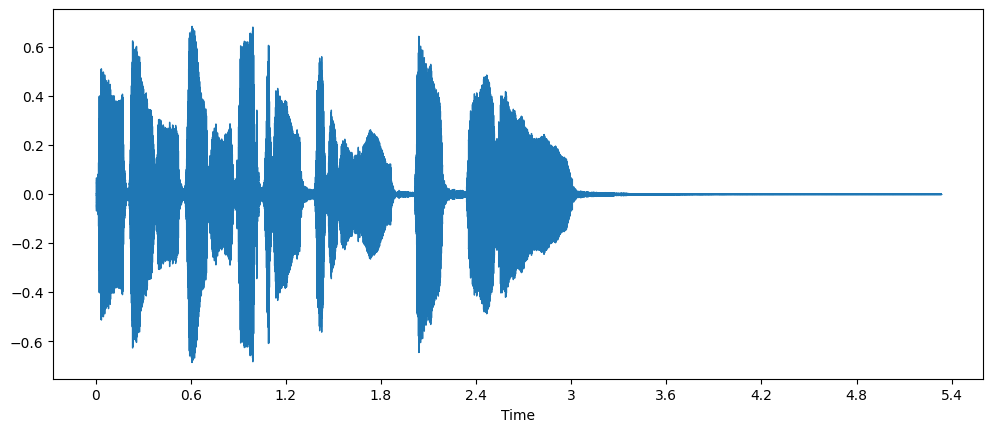

In [4]:
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr = sampling_rate)

In [5]:
import numpy as np

In [6]:
dft_input = array[:4096]

In [7]:
window =  np.hanning(len(dft_input))
windowed_input= dft_input * window
dft = np.fft.rfft(windowed_input)

In [8]:
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref= np.max)

In [9]:
frequency= librosa.fft_frequencies(sr= sampling_rate, n_fft = len(dft_input))

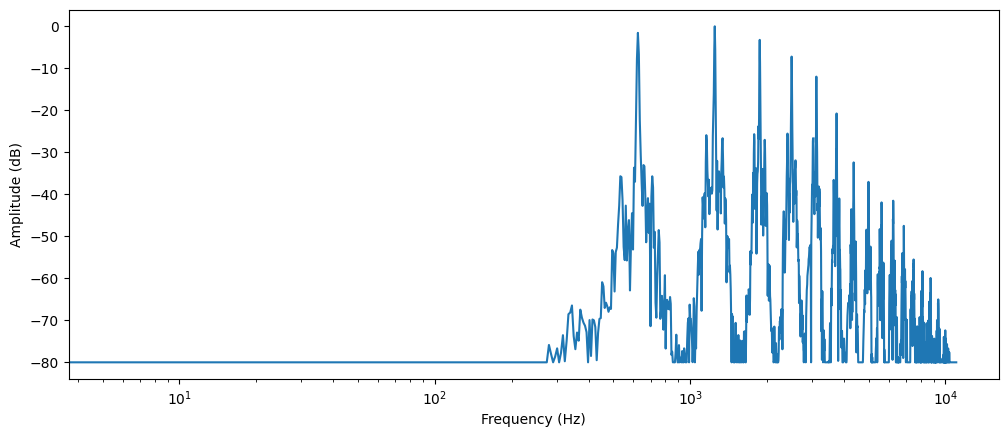

In [10]:
plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

In [11]:
import numpy as np

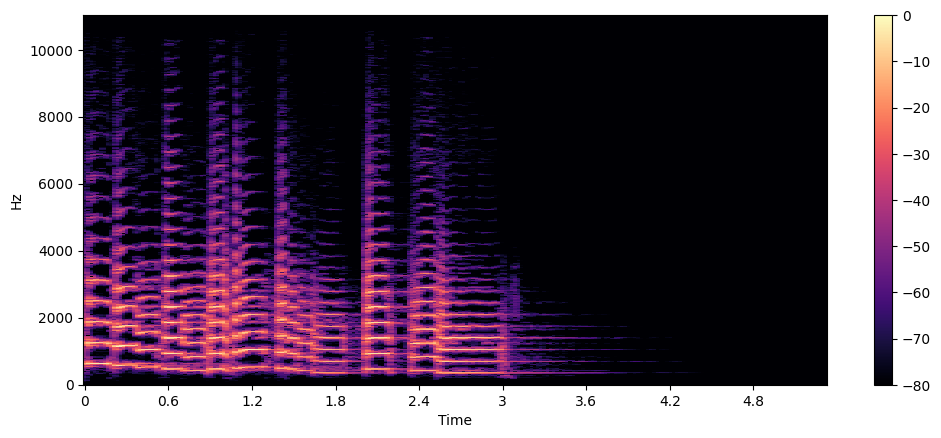

In [12]:
D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis = "time" , y_axis = "hz")
plt.colorbar()

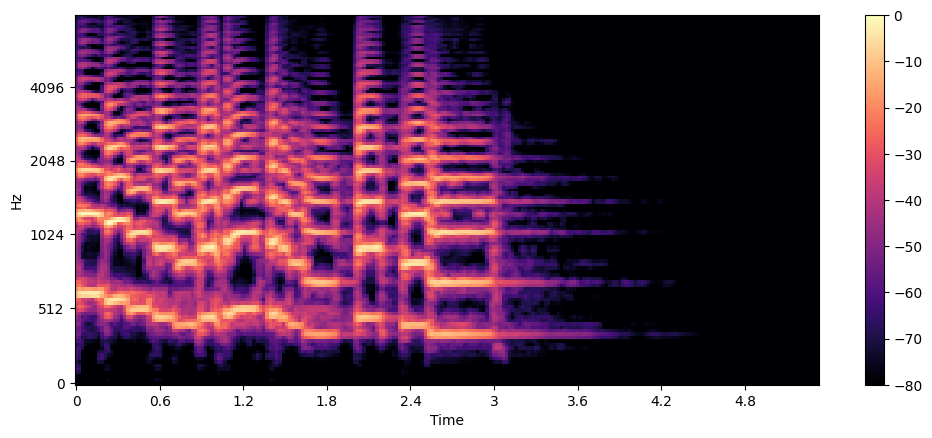

In [13]:
S = librosa.feature.melspectrogram(y= array, sr = sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref = np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB , x_axis = "time", y_axis="mel", sr= sampling_rate , fmax=8000)
plt.colorbar()

Compared to a standard spectrogram, a mel spectrogram can capture more meaningful features of the audio signal for human perception, making it a popular choice in tasks such as speech recognition, speaker identification, and music genre classification.

In [14]:
pip install datasets[audio]

Note: you may need to restart the kernel to use updated packages.


In [15]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", trust_remote_code=True, name="en-AU", split="train")
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [16]:
example = minds[0]
example

{'path': 'C:\\Users\\user\\.cache\\huggingface\\datasets\\downloads\\extracted\\2d94581c1e4b3a3f92a19fda0c5a2c0e6d43cd149665103e14cd6d076e529775\\en-AU~PAY_BILL\\response_4.wav',
 'audio': {'path': 'C:\\Users\\user\\.cache\\huggingface\\datasets\\downloads\\extracted\\2d94581c1e4b3a3f92a19fda0c5a2c0e6d43cd149665103e14cd6d076e529775\\en-AU~PAY_BILL\\response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [17]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [18]:
columns_to_remove = ["lang_id","english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [19]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [20]:
import gradio as gr

In [ ]:
def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])

with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label= generate_audio()
            output = gr.Audio(audio, label= label)

demo.launch(debug= True)        

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\processing_utils.py:749: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [ ]:
MAX_DUR_IN_SEC = 20.0

def is_audio_length_in_range(input_length):
    return input_length < MAX_DUR_IN_SEC 

In [ ]:
import librosa
new_column = [librosa.get_duration(path = x) for x in minds["path"]]
minds = minds.add_column("duration" , new_column)

In [ ]:
minds = minds.filter(is_audio_length_in_range, input_columns =["duration"])

In [ ]:
minds = minds.remove_columns(["duration"])
minds

In [ ]:
pip install transformers

In [ ]:
from transformers import WhisperFeatureExtractor
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [ ]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(audio["array"], sampling_rate= audio["sampling_rate"], padding= True)
    return features

In [ ]:
minds = minds.map(prepare_dataset)
minds